In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import line_search
import random

# Function

In [53]:
# Define the Rosenbrock function
def rosenbrock(x):
    """
    Rosenbrock function.
    f(x, y) = (a - x)^2 + b * (y - x^2)^2
    Commonly, a=1 and b=100.
    """
    a = 1.0
    b = 100.0
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2


# Define the gradient of the Rosenbrock function
def rosenbrock_gradient(x):
    """
    Gradient of the Rosenbrock function.
    df/dx = -2*(a-x) - 2*b*(y-x^2)*2*x
    df/dy = 2*b*(y-x^2)
    """
    a = 1.0
    b = 100.0
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)
    df_dy = 2 * b * (x[1] - x[0] ** 2)
    return np.array([df_dx, df_dy])


# Define the Hessian of the Rosenbrock function
def rosenbrock_hessian(x):
    """
    Hessian of the Rosenbrock function.
    d2f/dx2 = 2 - 4*b*(y-3*x^2)
    d2f/dy2 = 2*b
    d2f/dxdy = -4*b*x
    d2f/dydx = -4*b*x
    """
    a = 1.0
    b = 100.0
    h11 = 2 - 4 * b * (x[1] - 3 * x[0] ** 2)
    h12 = -4 * b * x[0]
    h21 = -4 * b * x[0]
    h22 = 2 * b
    return np.array([[h11, h12], [h21, h22]])


# Golden Section Search for optimal step size
def golden_section_search(func, x_k, p_k, a=0, b=1, tol=1e-5, max_iter=100):
    """
    Golden Section Search for finding the optimal step size.
    Minimizes func(x_k + alpha * p_k) with respect to alpha.

    Args:
        func: The objective function.
        x_k: Current point.
        p_k: Search direction.
        a: Lower bound for alpha.
        b: Upper bound for alpha.
        tol: Tolerance for the search interval.
        max_iter: Maximum number of iterations.

    Returns:
        The optimal step size alpha.
    """
    phi = (1 + np.sqrt(5)) / 2  # Golden ratio
    resphi = 2 - phi

    x1 = a + resphi * (b - a)
    x2 = b - resphi * (b - a)

    f1 = func(x_k + x1 * p_k)
    f2 = func(x_k + x2 * p_k)

    for i in range(max_iter):
        if abs(b - a) < tol:
            return (a + b) / 2

        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + resphi * (b - a)
            f1 = func(x_k + x1 * p_k)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = b - resphi * (b - a)
            f2 = func(x_k + x2 * p_k)

    return (a + b) / 2



In [54]:

random_state = 42
np.random.seed(random_state)

initial_x = np.random.uniform(-2, 2, 2)
print(f"Initial approximation (random_state={random_state}): {initial_x}")
print(f"Initial function value: {rosenbrock(initial_x)}")

FUNCTION_TOLERANCE = 10e-5
FUNCTION_MAX_ITER = 10000

Initial approximation (random_state=42): [-0.50183952  1.80285723]
Initial function value: 242.82006316689603


# Метод Ньютона

In [55]:
# --- Newton's Method Definition ---
def newton_method(
    func, grad, hess, x0, tol=FUNCTION_TOLERANCE, max_iter=1000, line_search_method=None
):
    """
    Newton's Method for unconstrained optimization.

    Args:
        func: The objective function.
        grad: The gradient of the objective function.
        hess: The Hessian of the objective function.
        x0: Initial guess.
        tol: Tolerance for the function value.
        max_iter: Maximum number of iterations.
        line_search_method: Function for line search (e.g., golden_section_search).

    Returns:
        x_k: The found minimum point.
        f_values: List of function values at each iteration.
        iterations: Number of iterations performed.
        operations: Dictionary counting function, gradient, Hessian evaluations, and inverse operations.
        x_path: List of x_k values at each iteration.
    """
    x_k = np.array(x0, dtype=float)
    f_values = [func(x_k)]
    x_path = [x_k.copy()]  # Store initial point
    operations = {"func_evals": 1, "grad_evals": 0, "hess_evals": 0, "inv_ops": 0}

    for i in range(max_iter):
        gradient = grad(x_k)
        hessian = hess(x_k)
        operations["grad_evals"] += 1
        operations["hess_evals"] += 1

        try:
            hessian_inv = np.linalg.inv(hessian)
            operations["inv_ops"] += 1
        except np.linalg.LinAlgError:
            break

        p_k = -np.dot(hessian_inv, gradient)

        alpha = 1.0

        if line_search_method:
            alpha = line_search_method(func, x_k, p_k)
            if alpha is None:
                break

        x_k = x_k + alpha * p_k
        x_path.append(x_k.copy())  # Store current point
        current_f_value = func(x_k)
        f_values.append(current_f_value)
        operations["func_evals"] += 1

        if current_f_value < tol:
            break
    else:
        pass

    return x_k, f_values, i + 1, operations, x_path


# --- Newton's Method Usage ---
print("\n--- Running Newton's Method ---")
x_newton, f_values_newton, iter_newton, ops_newton, x_path_newton = newton_method(
    rosenbrock,
    rosenbrock_gradient,
    rosenbrock_hessian,
    initial_x,
    line_search_method=golden_section_search,
)
print(
    f"Newton's Method Result: x={x_newton}, f(x)={f_values_newton[-1]:.6f}, Iterations: {iter_newton}, Operations: {ops_newton}"
)



--- Running Newton's Method ---
Newton's Method Result: x=[0.99558475 0.99108911], f(x)=0.000020, Iterations: 15, Operations: {'func_evals': 16, 'grad_evals': 15, 'hess_evals': 15, 'inv_ops': 15}


# Метод Нестерова

In [56]:
# --- Nesterov's Accelerated Gradient Method Definition ---
def nesterov_method(
    func, grad, x0, tol=FUNCTION_TOLERANCE, max_iter=1000, learning_rate=0.01
):
    """
    Nesterov's Accelerated Gradient (NAG) Method.

    Args:
        func: The objective function.
        grad: The gradient of the objective function.
        x0: Initial guess.
        tol: Tolerance for the function value.
        max_iter: Maximum number of iterations.
        learning_rate: Initial learning rate (alpha).

    Returns:
        x_k: The found minimum point.
        f_values: List of function values at each iteration.
        iterations: Number of iterations performed.
        operations: Dictionary counting function and gradient evaluations.
        x_path: List of x_k values at each iteration.
    """
    x_k = np.array(x0, dtype=float)
    v_k = np.zeros_like(x0, dtype=float)  # Momentum term
    f_values = [func(x_k)]
    x_path = [x_k.copy()]  # Store initial point
    operations = {"func_evals": 1, "grad_evals": 0}

    for i in range(max_iter):
        t_k = (i + 1) / 2  # Simple Nesterov's coefficient
        y_k = x_k + (t_k / (t_k + 3)) * v_k  # Nesterov's acceleration

        gradient = grad(y_k)
        operations["grad_evals"] += 1

        # Check for NaN or inf in gradient
        if np.isnan(gradient).any() or np.isinf(gradient).any():
            print(
                f"Nesterov's Method: NaN or Inf encountered in gradient at iteration {i}. Stopping."
            )
            break

        v_k = v_k - learning_rate * gradient

        # Check for NaN or inf in v_k
        if np.isnan(v_k).any() or np.isinf(v_k).any():
            print(
                f"Nesterov's Method: NaN or Inf encountered in momentum at iteration {i}. Stopping."
            )
            break

        x_k = x_k + v_k
        x_path.append(x_k.copy())  # Store current point
        current_f_value = func(x_k)
        f_values.append(current_f_value)
        operations["func_evals"] += 1

        # Check for NaN or inf in function value
        if np.isnan(current_f_value) or np.isinf(current_f_value):
            print(
                f"Nesterov's Method: NaN or Inf encountered in function value at iteration {i}. Stopping."
            )
            break

        if current_f_value < tol:
            break
    else:
        pass

    return x_k, f_values, i + 1, operations, x_path


# --- Nesterov's Method Usage ---
print("\n--- Running Nesterov's Method ---")
# Adjusted learning rate for Rosenbrock to prevent overflow/NaN
x_nesterov, f_values_nesterov, iter_nesterov, ops_nesterov, x_path_nesterov = (
    nesterov_method(
        rosenbrock,
        rosenbrock_gradient,
        initial_x,
        learning_rate=0.00005,  # Further reduced learning rate
    )
)
print(
    f"Nesterov's Method Result: x={x_nesterov}, f(x)={f_values_nesterov[-1]:.6f}, Iterations: {iter_nesterov}, Operations: {ops_nesterov}"
)



--- Running Nesterov's Method ---
Nesterov's Method Result: x=[-3.72865633 13.90910115], f(x)=22.364063, Iterations: 1000, Operations: {'func_evals': 1001, 'grad_evals': 1000}


# SR1 Метод

In [57]:
# --- SR1 (Symmetric Rank-1) Quasi-Newton Method Definition ---
def sr1_method(func, grad, x0, tol=FUNCTION_TOLERANCE, max_iter=1000, line_search_method=None):
    """
    Symmetric Rank-1 (SR1) Quasi-Newton Method.
    Approximates the inverse Hessian.
    
    Args:
        func: The objective function.
        grad: The gradient of the objective function.
        x0: Initial guess.
        tol: Tolerance for the function value.
        max_iter: Maximum number of iterations.
        line_search_method: Function for line search (e.g., golden_section_search).
        
    Returns:
        x_k: The found minimum point.
        f_values: List of function values at each iteration.
        iterations: Number of iterations performed.
        operations: Dictionary counting function and gradient evaluations.
        x_path: List of x_k values at each iteration.
    """
    x_k = np.array(x0, dtype=float)
    n = len(x0)
    H_k = np.eye(n) # Initial approximation of the inverse Hessian
    
    f_values = [func(x_k)]
    x_path = [x_k.copy()] # Store initial point
    operations = {'func_evals': 1, 'grad_evals': 0, 'inv_ops': 0} # No hess_evals for quasi-Newton
    
    prev_grad = grad(x_k)
    operations['grad_evals'] += 1

    for i in range(max_iter):
        p_k = -np.dot(H_k, prev_grad)
        
        alpha = 1.0 

        if line_search_method:
            alpha = line_search_method(func, x_k, p_k)
            if alpha is None:
                break
        
        s_k = alpha * p_k # Step taken
        x_k_plus_1 = x_k + s_k
        
        current_grad = grad(x_k_plus_1)
        operations['grad_evals'] += 1
        
        y_k = current_grad - prev_grad # Change in gradient
        
        Hy = np.dot(H_k, y_k)
        denominator = np.dot(y_k, s_k) - np.dot(y_k, Hy)
        
        if abs(denominator) > 1e-8: # A small threshold to prevent numerical instability
            term = (s_k - Hy)
            H_k = H_k + np.outer(term, term) / denominator
        else:
            pass

        x_k = x_k_plus_1
        x_path.append(x_k.copy()) # Store current point
        prev_grad = current_grad
        
        current_f_value = func(x_k)
        f_values.append(current_f_value)
        operations['func_evals'] += 1
        
        if current_f_value < tol:
            break
    else:
        pass
            
    return x_k, f_values, i + 1, operations, x_path


# --- SR1 Method Usage ---
print("\n--- Running SR1 Method ---")
x_sr1, f_values_sr1, iter_sr1, ops_sr1, x_path_sr1 = sr1_method(
    rosenbrock, rosenbrock_gradient, initial_x, line_search_method=golden_section_search
)
print(
    f"SR1 Method Result: x={x_sr1}, f(x)={f_values_sr1[-1]:.6f}, Iterations: {iter_sr1}, Operations: {ops_sr1}"
)



--- Running SR1 Method ---
SR1 Method Result: x=[0.11039602 0.0029492 ], f(x)=0.799929, Iterations: 1000, Operations: {'func_evals': 1001, 'grad_evals': 1001, 'inv_ops': 0}


In [58]:
# Store results for later plotting and table generation
results = {
    "Newton": {
        "f_values": f_values_newton,
        "iterations": iter_newton,
        "operations": ops_newton,
        "x_path": np.array(
            x_path_newton
        ),  # Convert list of arrays to a single numpy array for easier plotting
    },
    "Nesterov": {
        "f_values": f_values_nesterov,
        "iterations": iter_nesterov,
        "operations": ops_nesterov,
        "x_path": np.array(x_path_nesterov),
    },
    "SR1": {
        "f_values": f_values_sr1,
        "iterations": iter_sr1,
        "operations": ops_sr1,
        "x_path": np.array(x_path_sr1),
    },
}


# Визуализация для каждого метода

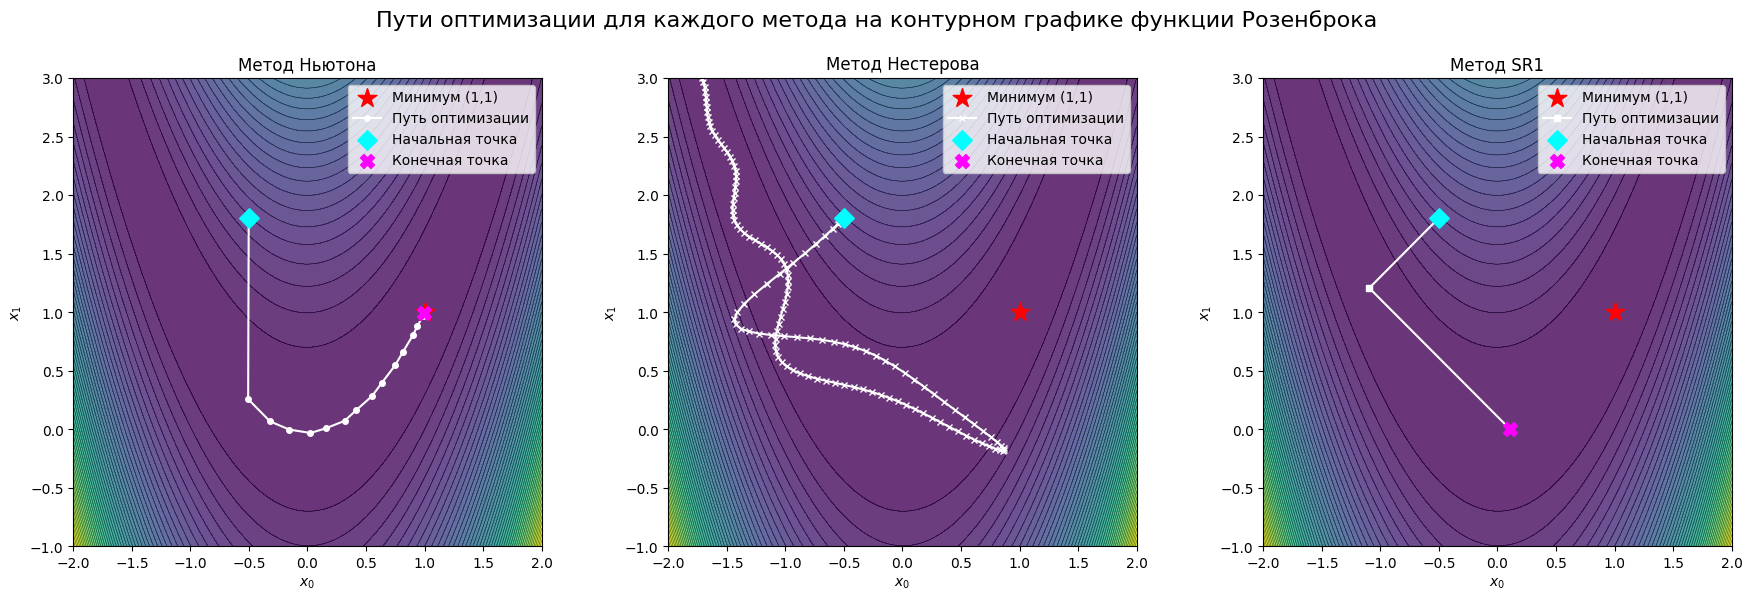

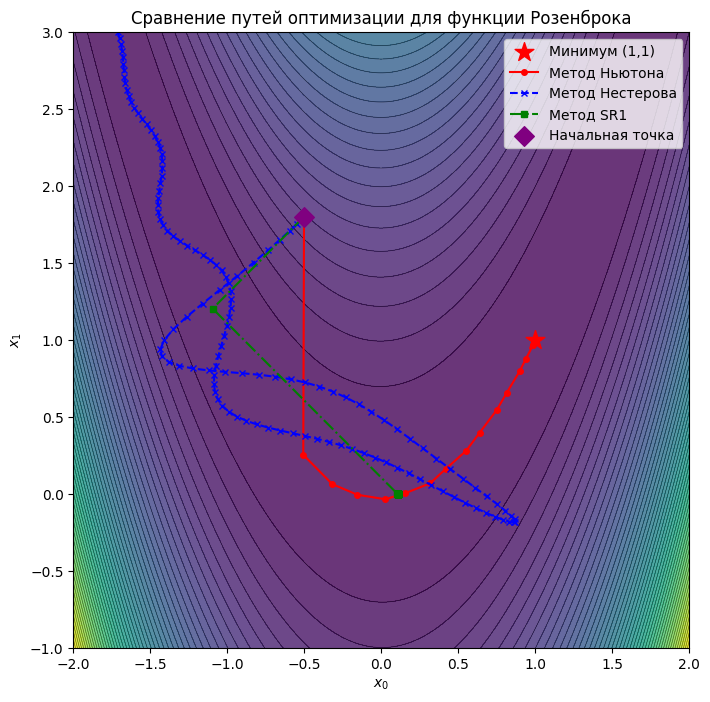

In [59]:
# This block assumes 'rosenbrock' function and 'results' dictionary are available.
# It also assumes matplotlib.pyplot as plt and numpy as np are imported.


def plot_rosenbrock_contour(ax, title, x_range=(-2, 2), y_range=(-1, 3), levels=50):
    """
    Helper function to plot the contour of the Rosenbrock function.

    Args:
        ax: Matplotlib axes object.
        title: Title for the plot.
        x_range: Tuple (min_x, max_x) for x-axis limits.
        y_range: Tuple (min_y, max_y) for y-axis limits.
        levels: Number of contour levels.
    """
    x = np.linspace(x_range[0], x_range[1], 400)
    y = np.linspace(y_range[0], y_range[1], 400)
    X, Y = np.meshgrid(x, y)
    Z = rosenbrock(np.array([X, Y]))

    ax.contourf(X, Y, Z, levels=levels, cmap="viridis", alpha=0.8)
    ax.contour(X, Y, Z, levels=levels, colors="black", linewidths=0.5, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_aspect(
        "equal", adjustable="box"
    )  # Keep aspect ratio for better visualization
    ax.scatter(
        1, 1, color="red", marker="*", s=200, label="Минимум (1,1)", zorder=5
    )  # Mark the true minimum
    ax.legend()

    # Set explicit limits for the axes to prevent plots from "running away"
    ax.set_xlim(x_range[0], x_range[1])
    ax.set_ylim(y_range[0], y_range[1])


# --- Plotting individual method paths ---
fig1, axes1 = plt.subplots(1, 3, figsize=(18, 6))
fig1.suptitle(
    "Пути оптимизации для каждого метода на контурном графике функции Розенброка",
    fontsize=16,
)

# Define common ranges for all plots to ensure consistency
common_x_range = (-2, 2)
common_y_range = (-1, 3)

# Newton's Method
if "Newton" in results and results["Newton"]["x_path"].shape[0] > 0:
    ax = axes1[0]
    plot_rosenbrock_contour(
        ax, "Метод Ньютона", x_range=common_x_range, y_range=common_y_range
    )
    ax.plot(
        results["Newton"]["x_path"][:, 0],
        results["Newton"]["x_path"][:, 1],
        color="white",
        linestyle="-",
        marker="o",
        markersize=4,
        label="Путь оптимизации",
    )
    ax.scatter(
        results["Newton"]["x_path"][0, 0],
        results["Newton"]["x_path"][0, 1],
        color="cyan",
        marker="D",
        s=100,
        label="Начальная точка",
        zorder=5,
    )
    ax.scatter(
        results["Newton"]["x_path"][-1, 0],
        results["Newton"]["x_path"][-1, 1],
        color="magenta",
        marker="X",
        s=100,
        label="Конечная точка",
        zorder=5,
    )
    ax.legend()

# Nesterov's Method
if "Nesterov" in results and results["Nesterov"]["x_path"].shape[0] > 0:
    ax = axes1[1]
    plot_rosenbrock_contour(
        ax, "Метод Нестерова", x_range=common_x_range, y_range=common_y_range
    )
    ax.plot(
        results["Nesterov"]["x_path"][:, 0],
        results["Nesterov"]["x_path"][:, 1],
        color="white",
        linestyle="-",
        marker="x",
        markersize=4,
        label="Путь оптимизации",
    )
    ax.scatter(
        results["Nesterov"]["x_path"][0, 0],
        results["Nesterov"]["x_path"][0, 1],
        color="cyan",
        marker="D",
        s=100,
        label="Начальная точка",
        zorder=5,
    )
    ax.scatter(
        results["Nesterov"]["x_path"][-1, 0],
        results["Nesterov"]["x_path"][-1, 1],
        color="magenta",
        marker="X",
        s=100,
        label="Конечная точка",
        zorder=5,
    )
    ax.legend()

# SR1 Method
if "SR1" in results and results["SR1"]["x_path"].shape[0] > 0:
    ax = axes1[2]
    plot_rosenbrock_contour(
        ax, "Метод SR1", x_range=common_x_range, y_range=common_y_range
    )
    ax.plot(
        results["SR1"]["x_path"][:, 0],
        results["SR1"]["x_path"][:, 1],
        color="white",
        linestyle="-",
        marker="s",
        markersize=4,
        label="Путь оптимизации",
    )
    ax.scatter(
        results["SR1"]["x_path"][0, 0],
        results["SR1"]["x_path"][0, 1],
        color="cyan",
        marker="D",
        s=100,
        label="Начальная точка",
        zorder=5,
    )
    ax.scatter(
        results["SR1"]["x_path"][-1, 0],
        results["SR1"]["x_path"][-1, 1],
        color="magenta",
        marker="X",
        s=100,
        label="Конечная точка",
        zorder=5,
    )
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to prevent title overlap
plt.show()

# --- Plotting all method paths on one graph ---
fig2, ax2 = plt.subplots(figsize=(10, 8))
plot_rosenbrock_contour(
    ax2,
    "Сравнение путей оптимизации для функции Розенброка",
    x_range=common_x_range,
    y_range=common_y_range,
)

if "Newton" in results and results["Newton"]["x_path"].shape[0] > 0:
    ax2.plot(
        results["Newton"]["x_path"][:, 0],
        results["Newton"]["x_path"][:, 1],
        color="red",
        linestyle="-",
        marker="o",
        markersize=4,
        label="Метод Ньютона",
    )

if "Nesterov" in results and results["Nesterov"]["x_path"].shape[0] > 0:
    ax2.plot(
        results["Nesterov"]["x_path"][:, 0],
        results["Nesterov"]["x_path"][:, 1],
        color="blue",
        linestyle="--",
        marker="x",
        markersize=4,
        label="Метод Нестерова",
    )

if "SR1" in results and results["SR1"]["x_path"].shape[0] > 0:
    ax2.plot(
        results["SR1"]["x_path"][:, 0],
        results["SR1"]["x_path"][:, 1],
        color="green",
        linestyle="-.",
        marker="s",
        markersize=4,
        label="Метод SR1",
    )

ax2.scatter(
    initial_x[0],
    initial_x[1],
    color="purple",
    marker="D",
    s=100,
    label="Начальная точка",
    zorder=5,
)
ax2.legend()
plt.show()

# Сравнение

Newton's Method: Final function value = 0.000020
Nesterov's Method: Final function value = 22.364063
SR1 Method: Final function value = 0.799929


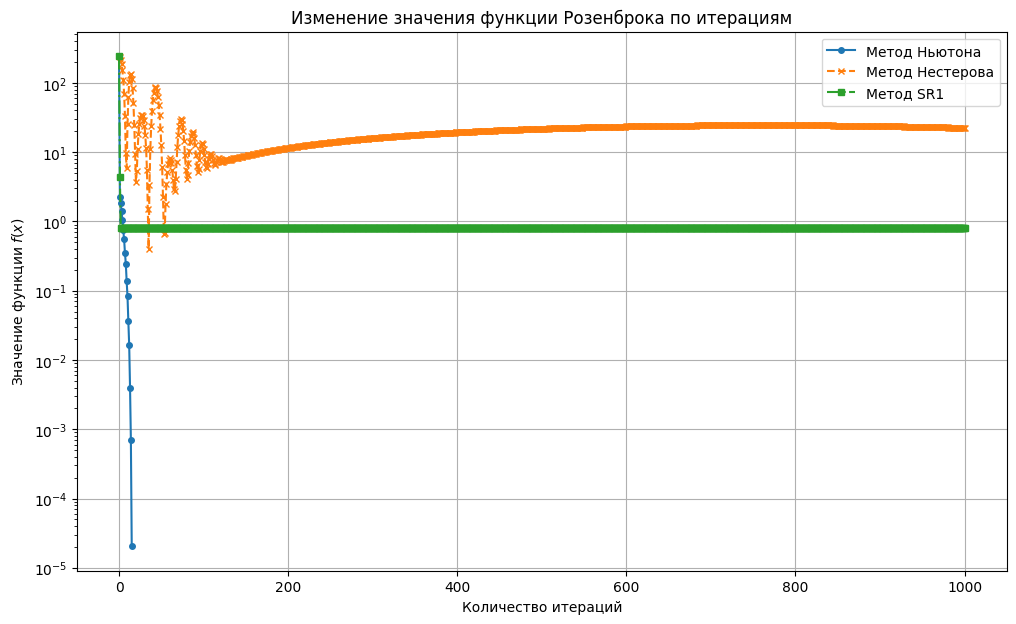

In [60]:

plt.figure(figsize=(12, 7))
plt.title("Изменение значения функции Розенброка по итерациям")
plt.xlabel("Количество итераций")
plt.ylabel("Значение функции $f(x)$")
plt.grid(True)
plt.yscale(
    "log"
)  # Use log scale for y-axis to better visualize convergence for Rosenbrock

# Plot Newton's Method results
if "Newton" in results and results["Newton"]["f_values"]:
    plt.plot(
        results["Newton"]["f_values"],
        label="Метод Ньютона",
        marker="o",
        markersize=4,
        linestyle="-",
    )
    print(
        f"Newton's Method: Final function value = {results['Newton']['f_values'][-1]:.6f}"
    )

# Plot Nesterov's Method results
if "Nesterov" in results and results["Nesterov"]["f_values"]:
    plt.plot(
        results["Nesterov"]["f_values"],
        label="Метод Нестерова",
        marker="x",
        markersize=4,
        linestyle="--",
    )
    print(
        f"Nesterov's Method: Final function value = {results['Nesterov']['f_values'][-1]:.6f}"
    )

# Plot SR1 Method results
if "SR1" in results and results["SR1"]["f_values"]:
    plt.plot(
        results["SR1"]["f_values"],
        label="Метод SR1",
        marker="s",
        markersize=4,
        linestyle="-.",
    )
    print(f"SR1 Method: Final function value = {results['SR1']['f_values'][-1]:.6f}")

plt.legend()
plt.show()
